##### top



# Main figures for the Reliability paper

* Methodological Figure 1 (not part of this ntb)
* [Figure 2](#Figure-2)
* [Figure 3](#Figure-3)
* [Figure 7](#Figure-7)
* [Figure 6](#Figure-6)
* [Figure 4](#Figure-4)
* [Figure 5](#Figure-5)




In [1]:
import os, sys
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from lmfit import Model
from lmfit import Parameters


# Define path and name
csv_clean_data_path = "../Data/cleaned_CSV" 
path_results = "../Data/results" 
path_figures = "./"
path_curve_fit = os.path.join(path_results, "curve_fits")
path_meaning = os.path.join(path_results, "reliability_meaning")
path_simulation_general = os.path.join(path_curve_fit, "compare_fitting_methods")

# Importing module for functions
functions_modul =  "../Code/functions"
sys.path.insert(0, functions_modul)


### Functions
from reliability_functions import linear, hyperbolic_fit, check_df_get_numbers, split_dataframes_faster_chunks, \
analytical_C, analytical_C_unbiased, create_random_reliability_curve
from plot_functions import label_correlation, plot_sampling_curves, plot_RC_distributions_line, label_column_height, \
plot_figure_convergent_tasks_random, sharey_ax


    
def sharey_name(a, source):
    """
    Takes name a of an axis that we want to share with an axis named source
    """
    # sharey, take the first axis and sharey with the last plotted one
    c.ax(a).sharey(c.ax(source))
    # need to rescale all axis        
    c.ax(a).autoscale()
    # remove ticks from shared y axes
    plt.setp(c.ax(a).get_yticklabels(), visible=False)
    # remove ylabel
    c.ax(a).set_ylabel('')



def human_label(x):
    if 'car' in x or 'emotion' in x:
        return x.replace('_', ' ').replace('ll', 'l').title()
    elif x == "VET_birds_planes_leaves":
        return "VET"
    elif x == "nback_concat_d_prime" or x == "nback_concat_level2_d_prime":
        return "N Back d'"
    elif x == "n_back":
        return "N Back"
    elif x == "CFMT_origFmonth":
        return "CFMT months apart"
    else:
        return x.replace('_', ' ')
    
    
# plots
colour_bigN = 'darkorange'

In [2]:
# these stats should be later used
df_prol=pd.read_csv('../Data/demographic_data/demographics_all_subjects.csv')

df_prol["age"] = pd.to_numeric(df_prol["Age"], errors="coerce")

print(f"Number of subjects: {df_prol['userID'].unique().size}")
print(f"Number of subjects per sex:\n{df_prol[['userID', 'Sex']].drop_duplicates()['Sex'].value_counts()}")
print(f"Mean age: {df_prol['age'].mean()}")
print(f"STD age: {df_prol['age'].std()}")

Number of subjects: 257
Number of subjects per sex:
Female          131
Male            120
DATA_EXPIRED      6
Name: Sex, dtype: int64
Mean age: 29.83730158730159
STD age: 7.740906338186192


## Figure 2
[top](#top)

In [3]:
# for tick frequency
import matplotlib.ticker as ticker

def plot_figure_convergent_tasks(file, task, ax, loc='best', alph=0.5, colour='r'):
    # load
    df_tmp = pd.read_csv(os.path.join(path_curve_fit,file))

    # extract values
    y = df_tmp["reliability"].values
    x = df_tmp["n_trials"].values

    title = task    
    if task == "CFMT":
        task += "_overall_correlation"
    elif task == "emotion_labelling":
        title = title.capitalize()

    n_tr = df_reliability.loc[(df_reliability["Task"].str.contains(task))&(df_reliability["version"]=="concat"),["num_trials"]].values[0][0]
    n_sub = df_reliability.loc[(df_reliability["Task"].str.contains(task))&(df_reliability["version"]=="concat"),["num_subjects"]].values[0][0]
    error = pd.read_csv(os.path.join(path_curve_fit, file.split('-')[0]+'.csv')).std().values
    
    # plot
    ax.errorbar(x, y, yerr=error, fmt='o', capsize=2, c=colour, alpha=alph, label=f'N={n_sub}, n trials={n_tr}')
    ax.set_title(f"{' '.join(title.split('_'))}")
    ax.legend(loc=loc)
    ax.set_xlabel('Number of trials, L')
    ax.set_ylabel('Reliability, R')
        
def plot_figure_convergent_tasks_bigN(file, task, ax, loc='best', alph=0.5, colour_bigN='darkorange'):
    # load
    df_tmp = pd.read_csv(os.path.join(path_curve_fit,file))

    # extract values
    y = df_tmp["reliability"].values
    x = df_tmp["n_trials"].values
    
    title = task    
    if task == "CFMT":
        task += "_overall_correlation"
    elif task == "emotion_labelling":
        title = title.capitalize()
        
    n_tr = df_reliability.loc[(df_reliability["Task"].str.contains(task))&(df_reliability["version"].isna()),["num_trials"]].values[0][0]
    n_sub = df_reliability.loc[(df_reliability["Task"].str.contains(task))&(df_reliability["version"].isna()),["num_subjects"]].values[0][0]
    error = pd.read_csv(os.path.join(path_curve_fit, file.split('-')[0]+'.csv')).std().values
    
    # plot
    ax.errorbar(x, y, yerr=error, fmt='o', capsize=2, c=colour_bigN, alpha=alph, label=f'N={n_sub}, n trials={n_tr}')
    ax.set_title(f"{' '.join(title.split('_'))}")
    ax.legend(loc=loc)
    ax.set_xlabel('Number of trials, L')    


def plot_reliability_hist_per_task(tmp, ax):
    # plot
    ax.bar(tmp['Task'], tmp['reliability_mean'], yerr=tmp['reliability_std'])

    ax.set_ylabel('Reliability, R')
    ax.set_xlabel('Task')

    ax.set_ylim(0,1)
    sns.despine(ax=ax)

def update_ticks(ax, xlabels='', rot=90, ha='center'):
    if not xlabels:
        # get ticks
        xlabels = [x.get_text().replace('_overall_correlation', '').replace('_orig_Aus', '').replace('_', ' ').replace(' correlation', '').replace('labelling', 'labeling').replace("faces-perc", "\ninterference - FM").replace("faces", "interference").replace("blank", "delay").replace("perception", "face matching").replace(" birds planes leaves 1form", "").replace("nback", "N Back").replace("N Back dprime level 2", "N Back d'") for x in ax.get_xticklabels()]
        # do some more cleaning
        xlabels = [x.title() if ('emotion' in x or 'car' in x) else x for x in xlabels]

    # align
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xlabels, rotation=rot, ha=ha)
    
    return xlabels



In [4]:
# define the simulation
total_n_trials = 70
# subjects
N=230

# define arrays
y_sim = np.zeros(17)
y_std = np.zeros(17)

array_corr_trials_psychofit = None
array_corr_trials_psychofit, n_trials_list = create_random_reliability_curve(total_n_trials, N,
                                                                             rng=np.random.default_rng(10),
                                                                             rng_split=np.random.default_rng(0))

# save the simulation results
y_sim = array_corr_trials_psychofit.mean(axis=1)
y_std = array_corr_trials_psychofit.std(axis=1)    

# define the simulation
total_n_trials_n = 250
# subjects
N_n=100

# define arrays
y_sim_n = np.zeros(25)
y_std_n = np.zeros(25)

array_corr_trials_psychofit = None
array_corr_trials_psychofit, n_trials_list_n = create_random_reliability_curve(total_n_trials_n, N_n,
                                                                             rng=np.random.default_rng(10),
                                                                             rng_split=np.random.default_rng(0))

# save the simulation results
y_sim_n = array_corr_trials_psychofit.mean(axis=1)
y_std_n = array_corr_trials_psychofit.std(axis=1)

print(f'Max correlation in the array: {array_corr_trials_psychofit.max()}')
print(f'Max correlation in the means: {y_sim_n.max()}')

Going over (2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34) trials per task, ie. 17 items
Process took: 9.74 s which is 0.16 min.
Going over (5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125) trials per task, ie. 25 items
Process took: 15.97 s which is 0.27 min.
Max correlation in the array: 0.3923311263768879
Max correlation in the means: 0.0679257575191369


#### Test that the average reliability curves are not significantly different from zero

See `statistical_dependance_tests.ipynb`.

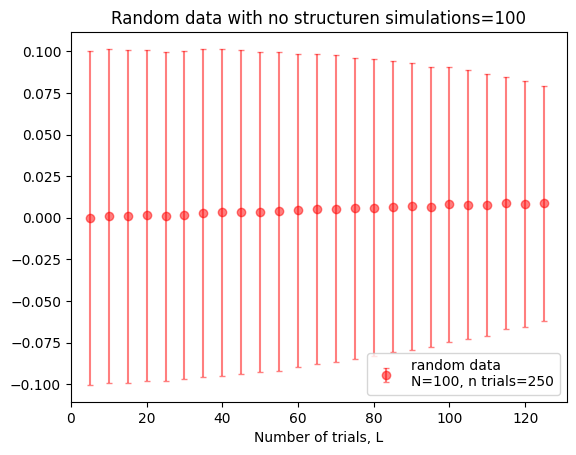

Ttest_1sampResult(statistic=1.1659805836168462, pvalue=0.24642362500678136)

(100,)

```python
import scipy
import numpy as np

array_corr_trials_psychofit_all = np.array([ 0.16875993,  0.10429556, -0.01582836,  0.07409064, -0.05922472,
       -0.05451658, -0.06937421,  0.07872501,  0.03851105, -0.03336555,
        0.06792576, -0.12521949,  0.00078065,  0.12140398,  0.00645836,
        0.0623742 ,  0.09133356, -0.1310829 ,  0.03328484, -0.10224572,
       -0.00820181,  0.08226455, -0.06516471, -0.02265822, -0.02564219,
       -0.04444007, -0.03502917,  0.01118365,  0.03164307, -0.08676045,
        0.14195758,  0.12543541,  0.02847046, -0.08568548, -0.01968092,
       -0.07164215,  0.2271621 ,  0.11267492, -0.01027024,  0.12863684,
        0.09069977,  0.04764545, -0.04165257,  0.10660245,  0.0450312 ,
        0.00174922,  0.09623391, -0.03403816, -0.0414793 , -0.00754224,
        0.06201173,  0.06372791,  0.05610683, -0.03800244, -0.01288502,
       -0.03861394,  0.03009583, -0.13084741, -0.07731847, -0.00835366,
        0.05190085, -0.02033788,  0.09394772,  0.00094973, -0.05628801,
        0.01044186, -0.07607847,  0.08659486, -0.02615993, -0.00823892,
       -0.0488006 , -0.04761604, -0.06818127,  0.04032473,  0.137606  ,
       -0.06454843, -0.1124142 ,  0.11294303,  0.0036926 ,  0.03720973,
        0.00078121, -0.12034546, -0.19769753,  0.02958366,  0.04887572,
        0.07324471,  0.07269103, -0.00242307, -0.07650207, -0.04839845,
       -0.03244388, -0.03948168,  0.06015638,  0.0564046 ,  0.01096322,
        0.01149261,  0.04201259,  0.0655781 ,  0.05222531, -0.02571074])

res = scipy.stats.ttest_1samp(array_corr_trials_psychofit_all, 0, alternative='two-sided')
print(res)
print(res.confidence_interval())
```

> TtestResult(statistic=1.1659806626978806, pvalue=0.2464235931832287, df=99)

> ConfidenceInterval(low=-0.006094515055468975, high=0.023463792855468974)


---

In [5]:
# load num trials data
df_reliability = pd.read_csv(os.path.join(path_results, 'reliability_summary.csv'))

# define selected files
selected_files = [
 'CFMT_longitudinal_reliability_5_chunks_psychofit_step5-fit.csv',
 'emotion_labelling_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
]

# define tasks
tasks = [x.split('_long')[0] for x in selected_files]

# plot it once again with more subjects and less trials    
colour_bigN = 'darkorange'
second_selected_files = [
    'CFMT_original_longitudinal_reliability_1_chunks_psychofit_step2-fit.csv',
    'emotion_labelling_orig_longitudinal_reliability_1_chunks_psychofit_step2-fit.csv'
]


## define data for the barplot -- have to have at least two tasks
reliability_selection = [
    'car_matching_overall_correlation', 'CCMT_overall_correlation',
    'MST_overall_correlation', 'MST_REC', 'MST_LDI',
    'GFMT_overall_correlation', 'emotion_matching_overall_correlation',
    'emotion_labelling_overall_correlation',
    'SCAP_overall_correlation', 'SCAP_Cowan_k_correlation',
#     'RISE_overall_correlation', # because we drop the second form, we only have one and that's not enough
    'CFMT_orig_Aus_overall_correlation',
    'PGNG_overall_correlation', 
    'PGNG_PCIT', 'PGNG_PCTT',
    'PIM_MC', 'PIM_recog',
    'FMP_overall_correlation',
    'nback_overall_correlation', 'nback_dprime_level_2', 
    ]

#one form
tmp = df_reliability.loc[(df_reliability['version']=='concat')&(df_reliability['Task'].isin(reliability_selection)), 
                   ['Task', 'reliability_mean', 'reliability_std']]

# add VET
tmp = pd.concat([tmp, df_reliability.loc[
    df_reliability["Task"]=="VET_birds_planes_leaves_1form_overall_correlation",
                 ['Task', 'reliability_mean', 'reliability_std']]])

tmp.sort_values(by='reliability_mean', inplace=True)
tmp

,Task,reliability_mean,reliability_std
42,emotion_matching_overall_correlation,0.601679,0.036018
135,SCAP_Cowan_k_correlation,0.618835,0.034640
89,PIM_recog,0.626908,0.036043
45,emotion_labelling_overall_correlation,0.629927,0.033744
60,GFMT_overall_correlation,0.680949,0.031988
159,nback_dprime_level_2,0.724506,0.035728
39,car_matching_overall_correlation,0.742801,0.024852
167,VET_birds_planes_leaves_1form_overall_correlation,0.786780,0.027733
69,MST_LDI,0.807047,0.028115
36,CFMT_orig_Aus_overall_correlation,0.811771,0.023158


{'name': 'Arial'}
Reliability convergence per selected tasks
Reliability of one form per task


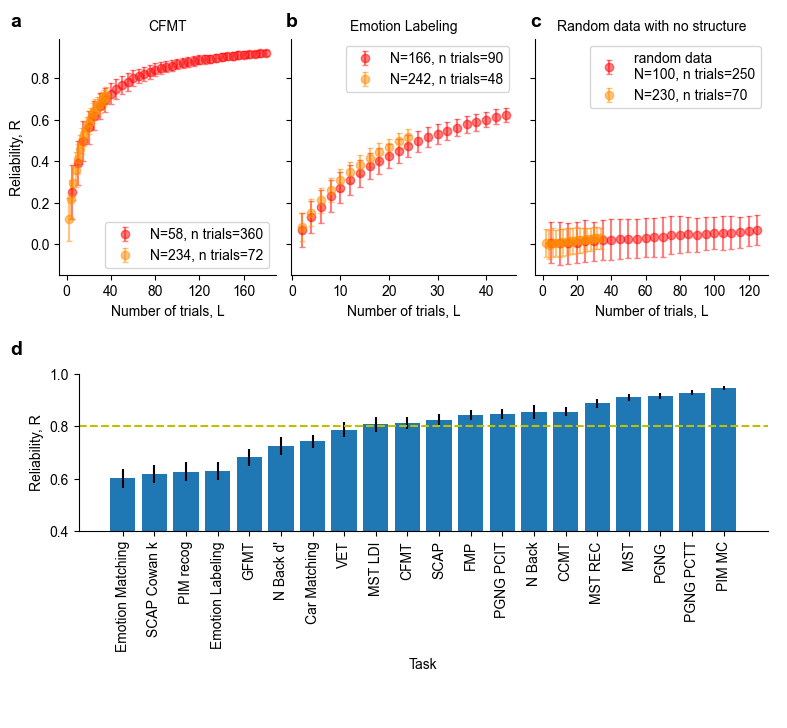

In [6]:
# define canvas

from cand import Canvas, Vector, Point

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 18.5
# rot = 15
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10)

# letters
c.add_text("a", Point(.02, 0.97), weight="bold", size=font_size)
c.add_text("d", Point(.02, 0.52), weight="bold", size=font_size)
c.add_text("b", Point(.37, 0.97), weight="bold", size=font_size)
c.add_text("c", Point(.68, 0.97), weight="bold", size=font_size)
           
# titles
titles = ["Reliability convergence per selected tasks", "Reliability of one form per task"]
# c.add_text(titles[0], Point(.55, 0.97), size=font_size)
# c.add_text(titles[1], Point(.55, 0.48), size=font_size)
for title in titles:
    print(title)


# ### GRID
# # top row
c.add_grid(["CFMT"]             , 1, Point(1.5,        b//2+2.5, "cm"), Point(a//3+1,   b-1, "cm"), spacing=Vector(.5, 2.5, "cm"), unitname="grid")
c.add_grid(["emotion_labelling"], 1, Point(a//3+1.4,   b//2+2.5, "cm"), Point(2*a//3+.1,b-1, "cm"), spacing=Vector(.5, 2.5, "cm"))
c.add_grid(["rand"]             , 1, Point(2*a//3+0.6, b//2+2.5, "cm"), Point(a-.5,     b-1, "cm"), spacing=Vector(.5, 2.5, "cm"))

# bottom row  
c.add_grid(["reliability"], 1, Point(2, 5, "cm"),  Point(a-.5,  b//2, "cm"), spacing=Vector(.5, 2.5, "cm"))



for (i,file), task in zip(enumerate(selected_files), tasks): 
    plot_figure_convergent_tasks(file, task, c.axes[task])
    
for (i,file), task in zip(enumerate(second_selected_files), tasks): 
    plot_figure_convergent_tasks_bigN(file, task, c.axes[task])
    
for n, a, a_std, bigN, colour in zip([n_trials_list_n, n_trials_list],[y_sim_n, y_sim], [y_std_n, y_std], [False, True], ['r', colour_bigN]):
    plot_figure_convergent_tasks_random(n, a, a_std, c.axes['rand'], bigN, colour=colour, N=N, N_n=N_n, total_n_trials=total_n_trials, total_n_trials_n=total_n_trials_n)
    
for tsk in ["CFMT","emotion_labelling", "rand"]:
    sns.despine(ax=c.axes[tsk])
    

# go by 20 on the x-axis
c.axes['CFMT'].xaxis.set_major_locator(ticker.MultipleLocator(40))
c.axes['emotion_labelling'].xaxis.set_major_locator(ticker.MultipleLocator(10))
c.axes['rand'].xaxis.set_major_locator(ticker.MultipleLocator(20))

# share axes
for tsk in ["emotion_labelling", "rand"]:
    sharey_name(tsk, "CFMT")    

# spelling
c.axes['emotion_labelling'].set_title(c.axes['emotion_labelling'].get_title().replace('ll','l').title()) # .title() for capitalisation

### plot bottom row    
plot_reliability_hist_per_task(tmp, c.axes['reliability'])
tick_order = update_ticks(c.axes['reliability'])

c.axes['reliability'].set_ylim(0.4,1)
c.axes['reliability'].axhline(0.8, linestyle='--', c='y')

# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "Fig2", 'Figure_2.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig2", 'Figure_2.pdf'), dpi=300)#, bbox_inches="tight")

---

## Figure 3

[top](#top)

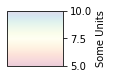

In [7]:
import matplotlib as mpl

# need to define fig, don't know how to go around this
fig, ax = plt.subplots(figsize=(1, 2))
fig.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)
cmap=sns.color_palette("Spectral", n_colors=4, as_cmap=True)

fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), alpha=0.2,
             cax=ax, orientation='vertical', label='Some Units')



def colourbar(ax, cmap, norm, alpha=0.2, title='Reliability', orientation='horizontal', **kwargs):
    clb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), alpha=alpha,
             cax=ax, orientation=orientation, **kwargs)
    clb.ax.set_title(title)
    return clb

### Only two panels
[top](#top)

#### With attenuation correction

{'name': 'Arial'}

CCMT-car-matching: max: 0.8499999999999999, min: 0.2
CCMT-SCAP: max: 0.8499999999999999, min: 0.2
PGNG-car-matching: max: 0.8499999999999999, min: 0.2


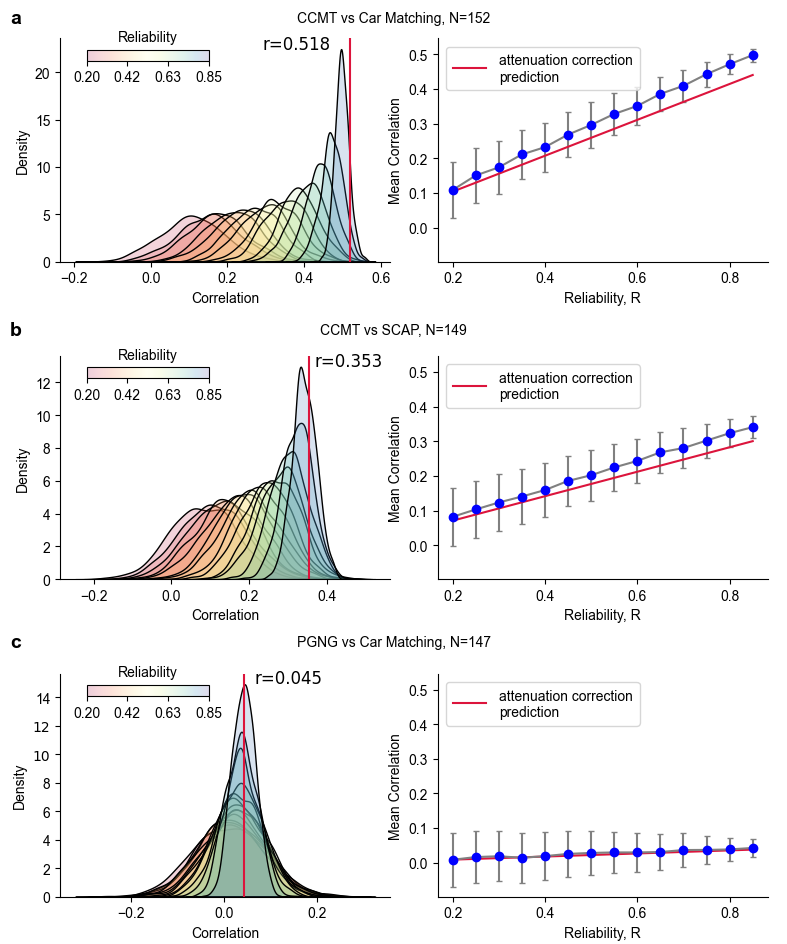

<Figure size 640x480 with 0 Axes>

In [8]:
#######################
# define canvas

from cand import Canvas, Vector, Point

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10


# CanD
a = 20
b = 24
# rot = 15
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10)

# letters
c.add_text("a", Point(.02, 0.98), weight="bold", size=font_size)
c.add_text("b", Point(.02, 0.65), weight="bold", size=font_size)
c.add_text("c", Point(.02, 0.32), weight="bold", size=font_size)
           
# titles
titles = ['']
for title in titles:
    print(title)

# ### GRID
# # top row, panel A
top_offset = 1.#5
bottom_offset = 1.2#5
right_offset = 1.53
hsb = 1.2 #half_space_between - horizontal
vsb = 2.4 #half_space_between - vertical

# add a 3x2 grid, "High Reliability, High/Middle/Low Correlation"
c.add_grid(["hrhc1", "hrhc2", "hrmc1", "hrmc2", "hrlc1", "hrlc2"], 3, Point(right_offset, bottom_offset, "cm"), Point(a-0.5, b-top_offset, "cm"), spacing=Vector(hsb, vsb, "cm"), unitname="grid")


# define loading dic
corr_rel_task_dic = {
    'emotion-labelling-matching': 152,
    'CFMT-MST': 63,
    'CCMT-SCAP': 149,
    'PGNG-PIM-MC': 123,
    'CCMT-car-matching':152,
    'PGNG-car-matching':147,
    'CFMT-FMP': 63,
    'MST-PIM-MC':74, 
}

# plot all together
for ax, (i,test), x_l, y_l, y_title in zip(["hrhc1", "hrmc1", "hrlc1"], 
                                  enumerate(['CCMT-car-matching', 'CCMT-SCAP', 'PGNG-car-matching']),
                                  [.56, 1.04, 1.5],
                                  [22.5, 13, 15],
                                  [0.98, 0.65, 0.32],
                                 ):
    N = corr_rel_task_dic[test]
    n_corr_repeats = 1000
    np_load = None

    # load
    np_load = np.load(os.path.join(path_meaning, f'{test}_correlation_per_reliability_N{N}_rep{n_corr_repeats}.npz'))

    # check that the data fits
    assert np_load["N"][0] == N
    assert np_load["n_corr_repeats"][0] == n_corr_repeats

    plot_RC_distributions_line(np_load["corr_distribution_array"], np_load["reliabilities"], np_load["max_rel_thr"], 
                               title='',#f'Correlation coefficient between Emotion {test.split("-")[1]} and {test.split("-")[2]}, {n_corr_repeats} repeats, N={N}, concatenated visits',
                               axs = np.array([c.ax(ax), c.ax(ax.replace("1", "2"))]),
                               legend_position=(.655,1.2), frameon=False,
                               real_corr=np_load["real_corr"][0],
                               y_l=y_l, x_l=x_l,
                               legend_title='Reliability', corr_label=f'r={np_load["real_corr"][0]:.3f}'
                              )

    #remove legend
    c.ax(ax).legend().remove()
    # get limits for colorscale
    max_rel = np_load["reliabilities"].max()
    min_rel = np_load["reliabilities"].min()
    print(f'{test}: max: {max_rel}, min: {min_rel}')

    # prepare colourbar
    norm = mpl.colors.Normalize(vmin=min_rel, vmax=max_rel)
    cmap=sns.color_palette("Spectral", n_colors=np_load["corr_distribution_array"].shape[0], as_cmap=True)
    # create an axis for it
    c.add_grid([f"colourbar{i}"], 1, Point(0.08,0.9, f"axis_{ax}"),Point(0.45,.95, f"axis_{ax}"), spacing=Vector(0.5, 0.5, "cm"))
    colourbar(c.ax(f"colourbar{i}"), cmap, norm, ticks=np.linspace(min_rel, max_rel,4), format="{x:.2f}")


    # fix title for scap and car matching
    if "matching" in test:
        title_correction = f" {test.split('-')[-1].capitalize()}"
    else:
        title_correction = ""
    c.add_text(' vs '.join(test.replace('c', 'C').split('-')[:2])+f"{title_correction}, N={N}", Point(.5, y_title))    

    # add attenuation correction prediction
    c.ax(ax.replace("1","2")).plot(np_load["reliabilities"], np_load["real_corr"]*np_load["reliabilities"], c='crimson', label='attenuation correction\nprediction')
    c.ax(ax.replace("1","2")).legend(loc="upper left")
    
# share y axis
for l in ["m", "l"]:
    c.ax(f"hr{l}c2").sharey(c.ax("hrhc2"))
    # need to rescale all axis
    c.ax(f"hr{l}c2").autoscale()
    
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "Fig3", 'Figure_3.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig3", 'Figure_3.pdf'), dpi=300)#, bbox_inches="tight")

---

## Figure 7


[top](#top)

Data for this figure are calculated elsewhere in a designated notebook.

---

## Figure 6


[top](#top)

In [9]:
def plot_needed_trials(data, ax, cmap=sns.color_palette('YlOrBr')[2::2], rot=90):
    
    plot = sns.barplot(data=data, x='nice_name', y='n_needed', ax=ax, 
                       hue="threshold", ci=None, palette=cmap)

    # get positions
    bar_positions = [bar.get_x() for bar in plot.axes.patches]
    bar_width = plot.axes.patches[0].get_width()

    # add the horizontal lines for one form
    for i, tsk in enumerate(data["task"].unique()):
        if i==0:
            label = 'one form'
        else:
            label = ''

        ax.hlines(y=df_estimate_needed_trials_thresholds.loc[df_estimate_needed_trials_thresholds["task"]==tsk, "one_form"].values[0], 
                  xmin=bar_positions[i], 
                  xmax=bar_positions[i]+2*bar_width,
                  linewidth=3, color='mediumblue', label=label)

    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
    ax.set_ylabel('Number of needed trials')
    ax.set_xlabel('Task')

    # ax.set_ylim(0,1)
    sns.despine(ax=ax)
    ax.legend()


def plot_C_number_trials_dependence(data, ax, 
                                     cmap=sns.color_palette('YlOrBr'), bbox=(1,1), leg_title="Wanted reliability", **kwargs):

    for col, colour in zip([x for x in data.columns if x.startswith('n_needed')], cmap):

        sns.scatterplot(data=data,x="C", y=col, ax=ax,
                        color=colour, label=f'{col.split("_")[-1]}', **kwargs
                   )

    ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_ylabel("Number of needed trials")
    ax.legend(title=leg_title, bbox_to_anchor=bbox) # wanted reliability
    sns.despine(ax=ax)     

In [10]:

# define range on which to evaluate the fit
x_pred = np.arange(1,600,1)

files = [
 'CCMT_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'CFMT_longitudinal_reliability_5_chunks_psychofit_step5-fit.csv',
 'FMP_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'GFMT_longitudinal_reliability_4_chunks_psychofit_step2-fit.csv',
 'MST_LDI_longitudinal_reliability_2_chunks_psychofit_step4-fit.csv',
 'MST_REC_longitudinal_reliability_2_chunks_psychofit_step4-fit.csv',
 'MST_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'PGNG_PCIT_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'PGNG_PCTT_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'PGNG_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'PIM_MC_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'PIM_recog_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'RISE_longitudinal_reliability_1_chunks_psychofit_step1-fit.csv',
 'SCAP_Cowan_k_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv', 
 'SCAP_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'car_matching_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'emotion_labelling_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'emotion_matching_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'nback_concat_level2_d_prime_longitudinal_reliability_2_chunks_psychofit_step3-fit.csv',
 'n_back_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'VET_birds_planes_leaves_longitudinal_reliability_3_chunks_psychofit_step5-fit.csv'
]


# define tasks
tasks = [x.split('_long')[0] if x.split('_long')[0]!="RISE_concat" else x.split('_concat_long')[0] for x in files]
# define thresholds
reliability_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# define outcome
df_estimate_needed_trials_thresholds = pd.DataFrame(
    columns=["task", "one_form", "method", "C", "n_forms"]+[f"n_needed_{rel_thr}" for rel_thr in reliability_thresholds])


print(f"Processing {len(tasks)} tasks and {len(reliability_thresholds)} thresholds.")

# go over all the tasks
for file, task in zip(files, tasks): 
    one_form = None
    df_tmp=None
    df_tmp = pd.read_csv(os.path.join(path_curve_fit,file))

    y = df_tmp["reliability"].values
    x = df_tmp["n_trials"].values

    # get how many trials there are per the given task        
    if task == 'n_back':
        one_form = df_reliability.loc[(df_reliability["version"]=='1')&(df_reliability["Task"]=="nback_overall_correlation"),
                            "num_trials"].values[0]
        
    elif task =='nback_concat_level2_d_prime':
        one_form = df_reliability.loc[(df_reliability["version"]=='1')&(df_reliability["Task"]=="nback_dprime_level_2"),
                            "num_trials"].values[0]
        
    elif task == 'SCAP_Cowan_k':
        one_form = df_reliability.loc[(df_reliability["version"].isna())&(df_reliability["Task"]==task+"_correlation"),
                            "num_trials"].values[0]

    elif task in df_reliability["Task"].unique():
        one_form = df_reliability.loc[(df_reliability["version"].isna())&(df_reliability["Task"]==task),
                            "num_trials"].values[0]
        
    elif task.startswith("FMP_standalone"):
        one_form = df_reliability.loc[(df_reliability["version"]=="stand")&(df_reliability["Task"]==task.replace("_standalone","")),
                            "num_trials"].values[0]
        
    elif task.startswith("VET_"):
        one_form = df_reliability.loc[(df_reliability["version"].isna())&(df_reliability["Task"]==task+"_overall_correlation"),
                            "num_trials"].values[0]
    
    else:
        one_form = df_reliability.loc[(df_reliability["version"].isna())&(df_reliability["Task"]==task+"_overall_correlation"),
                            "num_trials"].values[0]

        
    # define dictionary for all the data
    dic_data = {"task": [task], "one_form": [one_form], "n_forms": [int(file.split('_chunks')[0][-1])], "method": ["data"]}
    dic_fit1 = {"task": [task], "one_form": [one_form], "n_forms": [int(file.split('_chunks')[0][-1])], "method": ["fit_theory"]}
    dic_fit2 = {"task": [task], "one_form": [one_form], "n_forms": [int(file.split('_chunks')[0][-1])], "method": ["corrected_fit_theory"]}
    dic_fit3 = {"task": [task], "one_form": [one_form], "n_forms": [int(file.split('_chunks')[0][-1])], "method": ["hyperbolic_fit"]}

    for rel_thr in reliability_thresholds:

        # check that we have reliability over rel_thr
        if df_tmp["reliability"].max()>rel_thr:
            # extract data from the curve and save
            dic_data[f"n_needed_{rel_thr}"] = [df_tmp.loc[df_tmp["reliability"]>rel_thr, "n_trials"].iloc[0]]
        else:
            dic_data[f"n_needed_{rel_thr}"] = np.nan
            
        
        ### do the fits
        # -- compute C_theor
        C_theor = analytical_C(df_tmp["mean_p"].iloc[-1], 
                                 df_tmp["var_p"].iloc[-1])        

        # do the fit and estimate
        y_pred_theor = hyperbolic_fit(x_pred, C_theor)
        # save
        dic_fit1[f"n_needed_{rel_thr}"] = x_pred[(y_pred_theor>rel_thr).argmax()]
        dic_fit1["C"] = C_theor
        
        # -- compute corrected C
        C_theor_corrected = analytical_C_unbiased(df_tmp["mean_p"].iloc[-1], 
                                                   df_tmp["var_p"].iloc[-1], x.max())
        # do the fit and estimate
        y_pred_theor_corr = hyperbolic_fit(x_pred, C_theor_corrected)
        # save
        dic_fit2[f"n_needed_{rel_thr}"] = x_pred[(y_pred_theor_corr>rel_thr).argmax()]
        dic_fit2["C"] = C_theor_corrected
        
        
        ## perform the fit
        # initiate the model
        gmodel = Model(hyperbolic_fit, nan_policy='omit')

        # set params, it differs for different functions, atm just one
        if len(gmodel.param_names) == 1:
            params = gmodel.make_params(a=0.3)
#             print(f"For model {gmodel.name} taking 1 param.")

            # perform the fit
        try:
            result = gmodel.fit(y, params, x=x)
            
            # create predictions
            y_pred_fit = hyperbolic_fit(x_pred, result.best_values["a"])
            
            # save
            dic_fit3["C"] = result.best_values["a"]
            dic_fit3[f"n_needed_{rel_thr}"] = x_pred[(y_pred_fit>rel_thr).argmax()]
            
        except ValueError:
            dic_fit3[f"n_needed_{rel_thr}"] = None
    
    # update the final dataframe
    df_estimate_needed_trials_thresholds = df_estimate_needed_trials_thresholds.append(pd.DataFrame(dic_data))
    df_estimate_needed_trials_thresholds = df_estimate_needed_trials_thresholds.append(pd.DataFrame(dic_fit1))
    df_estimate_needed_trials_thresholds = df_estimate_needed_trials_thresholds.append(pd.DataFrame(dic_fit2))
    df_estimate_needed_trials_thresholds = df_estimate_needed_trials_thresholds.append(pd.DataFrame(dic_fit3))
    

df_estimate_needed_trials_thresholds.reset_index(inplace=True, drop=True)    
# save the dataset
df_estimate_needed_trials_thresholds.to_csv(os.path.join(path_results, "needed_trials_thresholds.csv"), index=False)

# define range of C coefficient
Cs_data = df_estimate_needed_trials_thresholds.loc[df_estimate_needed_trials_thresholds["method"]=="hyperbolic_fit", "C"]


Processing 21 tasks and 5 thresholds.


In [11]:
# choose only one fit
df_task_thresholds_plot = df_estimate_needed_trials_thresholds.loc[df_estimate_needed_trials_thresholds["method"] == 'hyperbolic_fit',
                                              ["task", 'one_form', 'n_needed_0.8', 'n_needed_0.9']]

# drop VET subtasks
df_task_thresholds_plot = df_task_thresholds_plot.loc[~df_task_thresholds_plot["task"].isin(["VET_birds", "VET_planes", "VET_leaves"])]

# sort them for better orientation
# df_task_thresholds_plot.sort_values(by='n_needed_0.8', inplace=True)
df_task_thresholds_plot.sort_values(by='one_form', inplace=True)

# make it long format
df_task_thresholds_plot = df_task_thresholds_plot.melt(id_vars='task', var_name='threshold', value_name='n_needed')

# extract number
df_task_thresholds_plot["threshold"] = df_task_thresholds_plot["threshold"].str.split('d_').str[1]
# fill back one form
df_task_thresholds_plot["threshold"] = df_task_thresholds_plot["threshold"].fillna('one_form')

# add a nice name for plots
df_task_thresholds_plot["nice_name"] = df_task_thresholds_plot["task"].apply(human_label)

df_task_thresholds_plot

,task,threshold,n_needed,nice_name
0,PGNG_PCIT,one_form,25,PGNG PCIT
1,RISE,one_form,36,RISE
2,GFMT,one_form,40,GFMT
3,car_matching,one_form,40,Car Matching
4,nback_concat_level2_d_prime,one_form,45,N Back d'
...,...,...,...,...
58,PGNG_PCTT,0.9,82,PGNG PCTT
59,PGNG,0.9,119,PGNG
60,VET_birds_planes_leaves,0.9,169,VET
61,FMP,0.9,302,FMP


##### prepare data

In [12]:
# choose data
data = df_estimate_needed_trials_thresholds.loc[df_estimate_needed_trials_thresholds["method"].str.contains("fit"), :]

# choose specifically for the figure
data_C = data.loc[data["method"]=="hyperbolic_fit", ["task", "one_form", "C", "method"]].reset_index(drop=True)
data_C["nice_name"] = data_C["task"].apply(human_label)

# add reliability
tmp["task"] = tmp["Task"].str.replace('_correlation', '').str.replace('_overall', '')
data_C = data_C.merge(tmp.loc[:, set(tmp.columns)-set(['Task'])], how='outer')

# save the data
data_C.to_csv(os.path.join(path_results, 'C_data_per_task.csv'), index=False)

data

,task,one_form,method,C,n_forms,n_needed_0.5,n_needed_0.6,n_needed_0.7,n_needed_0.8,n_needed_0.9
1,CCMT,72,fit_theory,10.235873,2,11,16,24,41,93
2,CCMT,72,corrected_fit_theory,12.193002,2,13,19,29,49,110
3,CCMT,72,hyperbolic_fit,12.195325,2,13,19,29,49,110
5,CFMT,72,fit_theory,13.501214,5,14,21,32,55,122
6,CFMT,72,corrected_fit_theory,14.684207,5,15,23,35,59,133
...,...,...,...,...,...,...,...,...,...,...
78,n_back,45,corrected_fit_theory,6.979006,2,7,11,17,28,63
79,n_back,45,hyperbolic_fit,7.768775,2,8,12,19,32,70
81,VET_birds_planes_leaves,153,fit_theory,13.224959,3,14,20,31,53,120
82,VET_birds_planes_leaves,153,corrected_fit_theory,16.320382,3,17,25,39,66,147


In [13]:
# make it into a long format so that I can plot it the other way later
data_long = pd.DataFrame({
    "C": np.tile(data.loc[:, "C"], 5),
    "method": np.tile(data.loc[:, "method"], 5),
    "threshold": np.repeat([0.5, 0.6, 0.7, 0.8, 0.9], len(data)),
    "n_needed": pd.concat([data[x] for x in data.columns if x.startswith('n_needed')]).values,
})
data_long

,C,method,threshold,n_needed
0,10.235873,fit_theory,0.5,11
1,12.193002,corrected_fit_theory,0.5,13
2,12.195325,hyperbolic_fit,0.5,13
3,13.501214,fit_theory,0.5,14
4,14.684207,corrected_fit_theory,0.5,15
...,...,...,...,...
310,6.979006,corrected_fit_theory,0.9,63
311,7.768775,hyperbolic_fit,0.9,70
312,13.224959,fit_theory,0.9,120
313,16.320382,corrected_fit_theory,0.9,147


---

{'name': 'Arial'}
Needed trials per task, predicted from curves
Number of needed trials
depending on reliability thresholds for both fits
for different Cs
C coefficient per task


/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_88554/340973036.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(data=data, x='nice_name', y='n_needed', ax=ax,
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_88554/340973036.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_88554/2119953483.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.axes['C_values_tasks'].set_xticklabels(c.axes['C_values_tasks'].get_xticklabels(), rotation=90)


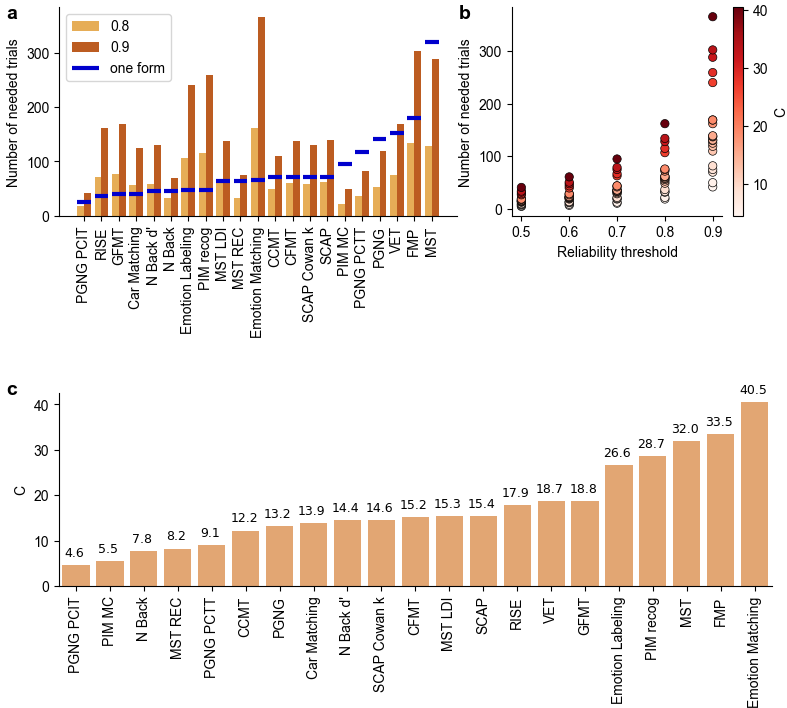

In [14]:
#######################
# define canvas

from cand import Canvas, Vector, Point

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10

# CanD
a = 20
b = 18

# rot = 15
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10)

# letters
c.add_text("a", Point(.015, 0.98), weight="bold", size=font_size)
c.add_text("b", Point(.59, 0.98), weight="bold", size=font_size)
c.add_text("c", Point(.015, 0.45), weight="bold", size=font_size)
           
# titles
titles = ["Needed trials per task, predicted from curves", "Number of needed trials\ndepending on reliability thresholds for both fits\nfor different Cs", "C coefficient per task"]
for title in titles:
    print(title)


# ### GRID
middle_point = 8
# # top row
# left
c.add_grid(["reliability"], 1, Point(1.5, middle_point+4.5, "cm"),  Point(2*a//3-1.4,  b-.2, "cm"), spacing=Vector(.5, 2.5, "cm"), unitname="grid")
# right
c.add_grid(["C_needed"], 1, Point(2*a//3, middle_point+4.5, "cm"), Point(a-.4, b-.2, "cm"), spacing=Vector(.5, 2.5, "cm"))
c.add_grid(["C_values_tasks"], 1, Point(1.5, 3.1, "cm"), Point(a-.4, middle_point, "cm"), spacing=Vector(.5, 2.5, "cm"))



#### Panel a
plot_needed_trials(df_task_thresholds_plot[df_task_thresholds_plot["threshold"]!="one_form"], c.axes['reliability'])
c.axes['reliability'].set_xlabel('')

#### Panel b

data_tmp=data_long[data_long["method"]=="hyperbolic_fit"].sort_values(by="C")
# create colourbar
norm = plt.Normalize(data_tmp["C"].min(), data_tmp["C"].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

sns.scatterplot(data=data_tmp,
                x="threshold", y="n_needed", 
                hue="C",
                ax=c.axes['C_needed'],
                palette='Reds', 
                edgecolor='k',
           )

# remove the old legend
c.axes['C_needed'].get_legend().remove()
# add colourbar that is part of the figure
c.axes['C_needed'].figure.colorbar(sm, ax=c.axes['C_needed'], label='C', pad=0.04)

c.axes['C_needed'].set_ylabel("Number of needed trials")
c.axes['C_needed'].set_xlabel("Reliability threshold")
sns.despine(ax=c.axes['C_needed'])


#### Panel c
sns.barplot(data=data_C.sort_values(by="C"), x="nice_name", y="C", ax=c.axes['C_values_tasks'], color='sandybrown')
# adjust
c.axes['C_values_tasks'].set_xticklabels(c.axes['C_values_tasks'].get_xticklabels(), rotation=90)
c.axes['C_values_tasks'].set_ylabel('C')
c.axes['C_values_tasks'].set_xlabel('Task')

sns.despine(ax=c.axes['C_values_tasks'])

label_column_height(c.axes['C_values_tasks'], y=2.7, size=9, n=1)

        
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
# #
c.save(os.path.join(path_figures, "Fig6", 'Figure_6.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig6", 'Figure_6.pdf'), dpi=300)#, bbox_inches="tight")

---

## Figure 4

[top](#top)

---

In [15]:
def plot_percent_distance_from_true_C_boxplot(df_helper, ax, my_N=100, my_C_min=2, my_C_max=50, y='percent_distance',
                                              cmap_fits='colorblind', c_hline='gray', no_extremes=True, rot=0, ha='center', **kwargs):
    
    # remove small sigmas
    if no_extremes and "small_sigma" in df_helper.columns:
        df_helper = df_helper[~df_helper["small_sigma"]].copy()
        
    if no_extremes and "exploded" in df_helper.columns:
        df_helper = df_helper[df_helper["exploded"]==0].copy()
    
        
    if type(my_N)==int:
        df_helper = df_helper[df_helper["N"]==my_N]
    elif type(my_N) == list or isinstance(my_N, np.ndarray):
        df_helper = df_helper[df_helper["N"].isin(my_N)]
    else:
        print(f'Variable my_N is neither int, nor list/array, it is {type(my_N)}, quitting.')
        raise ValueError(f'Variable my_N is neither int, nor list/array, it is {type(my_N)}, quitting.')
    
    # check that we only have 1 distribution
    assert len(df_helper["distribution"].unique()) == 1
    # plot
    sns.boxplot(data=df_helper[(df_helper["true_C"]<=my_C_max)&(df_helper["true_C"]>=my_C_min)], 
                   x='fit', y=y, ax=ax, showfliers=False, palette=cmap_fits, **kwargs)
    ax.axhline(0, c=c_hline)

    sns.despine(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rot, ha=ha)

    ax.set_ylabel('Percent distance from true C') 


In [16]:
def plot_perc_median_error_shaded(df_perc_median, Cs_data, ax, 
                                  fits_list=["hyperbolic", "linear", "theory_unbiased"],
                                  min_C_thr=2, max_C_thr=100, my_N=100, shaded_alpha=0.1, shaded_area_alpha=0.4,
                                  cmap_fits=['k', 'dodgerblue', 'darkorange'], shaded_area_colour='darkred',
                                  c_hline='gray'):

    
    # limit the max value to adjust for the ylim
    if max_C_thr is not None:
        df_perc_median = df_perc_median[df_perc_median["true_C"]<=max_C_thr]
        
    if min_C_thr is not None:
        df_perc_median = df_perc_median[df_perc_median["true_C"]>=min_C_thr]
        
    if type(my_N)==int:
        df_perc_median = df_perc_median[df_perc_median["N"]==my_N]
    elif type(my_N) == list or isinstance(my_N, np.ndarray):
        df_perc_median = df_perc_median[df_perc_median["N"].isin(my_N)]
    else:
        raise ValueError(f'Variable my_N is neither int, nor list/array, it is {type(my_N)}, quitting.')
        

    for (i,fit_hue), colour in zip(enumerate(fits_list), cmap_fits):
        data=df_perc_median.loc[(df_perc_median["fit"]==fit_hue)]
        # plot the data
        ax.scatter(data.loc[:, "true_C"], data.loc[:, "percent_error"], color=colour, label=f'{fit_hue}')
        # plot error
        ax.fill_between(
            data.loc[:, "true_C"],
            data.loc[:, "percent_error"]-data.loc[:, "percent_error_std_perN"],
            data.loc[:, "percent_error"]+data.loc[:, "percent_error_std_perN"],
            color=colour, alpha=shaded_alpha,
        )
        # plot edges of the error
        ax.plot(
            data.loc[:, "true_C"],
            data.loc[:, "percent_error"]-data.loc[:, "percent_error_std_perN"],
            color=colour, alpha=shaded_alpha,
        )
        ax.plot(
            data.loc[:, "true_C"],
            data.loc[:, "percent_error"]+data.loc[:, "percent_error_std_perN"],
            color=colour, alpha=shaded_alpha,
        )

    # plot zero line
    ax.axhline(0, c=c_hline)

    ax.axvline(Cs_data.min(), c='k')#, label=f'min observed\nC={Cs_data.min():.2f}')
    ax.axvline(Cs_data.max(), c='k')#, label=f'max observed\nC={Cs_data.max():.2f}')

    x = np.linspace(0,max_C_thr, 300)
    ax.fill_between(x, 0, 1, where= (x > Cs_data.min())& (x < Cs_data.max()),
                    color=shaded_area_colour, alpha=shaded_area_alpha, transform=ax.get_xaxis_transform())
    # https://matplotlib.org/stable/gallery/lines_Crs_and_markers/fill_between_demo.html

    ax.set_xlim(0, max_C_thr)

    ax.set_ylabel('')
    ax.set_xlabel('True C')
    ax.set_title(f'N = {my_N}')

    # plot legend
    ax.legend()

    sns.despine(ax=ax)


In [17]:
def plot_app_vs_data_predictions(df_estimate_n_needed, ax, rot=85, ha='right', plot_errors=False, app_colour='royalblue'):

    if plot_errors:
        # plot app with errorbars
        ax.errorbar(
            np.arange(1,len(df_estimate_n_needed)+1),
            y=df_estimate_n_needed['n_needed_08_app'],
            yerr=(df_estimate_n_needed['n_needed_08_app']-df_estimate_n_needed['n_needed_08_app_low'],
            df_estimate_n_needed['n_needed_08_app_high']-df_estimate_n_needed['n_needed_08_app']),
            fmt='o', capsize=3, label='MV', c=app_colour, alpha=0.8,

        )
    else:
        ax.scatter(
            np.arange(1,len(df_estimate_n_needed)+1),
            df_estimate_n_needed['n_needed_08_app'],
            label='MV', c=app_colour, alpha=0.8,
        )

    # plot estimates from curves
    ax.scatter(
        np.arange(1,len(df_estimate_n_needed)+1),
        df_estimate_n_needed['n_needed_08_data'],
        c='k', alpha=0.6, label='data'
    )

    ax.set_xticks(np.arange(1,len(df_estimate_n_needed)+1))
    ax.set_xticklabels(df_estimate_n_needed['nice_name'].values, rotation=rot, ha=ha, size=legend_size)
    ax.set_ylabel('Number of needed trials')
    ax.set_xlabel('Task')
    ax.legend()
    
    sns.despine(ax=ax)

### Load the data
[top](#top)

In [18]:
df_perc_median_noexplosions = pd.read_csv(os.path.join(path_simulation_general, 'beta_simulate_N_ntrials250', 'df_perc_median_noexplosions_varyN_ntrials_250_unbiasedC_between_1-100.csv'))

df = pd.read_csv(os.path.join(path_simulation_general, 'beta_simulate_N_ntrials250', 'all_simulations_varyN_ntrials_250_C_between_1-100.csv'))

df["total_n_trials"] = 250

# get data into a long format
df_helper = pd.DataFrame({
    "C_distance_from_true": np.concatenate([
                df["fit_hyperbolic_dist"].values, 
                df["fit_linear_dist"].values,
                df["fit_theoretical_unbiased_dist"].values,
                                           ]),
    "distribution": df["distribution"].tolist()*3,
    "N": df["N"].tolist()*3,
    "fit": ["hyperbolic"]*len(df) + ["linear"]*len(df) + ["theory_unbiased"]*len(df),#["theory"]*len(df),
    "exploded": df["exploded"].tolist()*3,
    "true_C": df["true_C"].tolist()*3
})

# add percent distance
df_helper["percent_distance"] = 100*df_helper["C_distance_from_true"]/df_helper["true_C"]



In [19]:
df_perc_median_noexplosions.loc[(df_perc_median_noexplosions["fit"]=="theory_unbiased")&(df_perc_median_noexplosions["N"]==10)]

,fit,percent_error,percent_error_std_perN,true_C,N,total_n_trials,distribution
4740,theory_unbiased,15.686661,89.406823,2.000449,10,250,beta
4760,theory_unbiased,13.469255,84.968159,3.000800,10,250,beta
4780,theory_unbiased,13.721157,87.653895,4.000217,10,250,beta
4800,theory_unbiased,14.968208,95.518689,5.001079,10,250,beta
4820,theory_unbiased,14.606354,101.251395,6.000053,10,250,beta
...,...,...,...,...,...,...,...
6220,theory_unbiased,17.172801,66.504353,75.966943,10,250,beta
6240,theory_unbiased,17.248210,66.161247,76.992372,10,250,beta
6260,theory_unbiased,17.312562,65.876771,77.989321,10,250,beta
6280,theory_unbiased,17.203118,64.910333,78.949836,10,250,beta


In [20]:
# define outcome
df_estimate_n_needed = pd.DataFrame(columns=["task", "n_needed_08_data", "n_needed_08_app", "n_needed_08_app_low", "n_needed_08_app_high", "C"])

# define range on which to evaluate the fit
x_pred = np.arange(1,600,1)

files = [
 'CCMT_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'CFMT_longitudinal_reliability_5_chunks_psychofit_step5-fit.csv',
 'FMP_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'GFMT_longitudinal_reliability_4_chunks_psychofit_step2-fit.csv',
#  'MST_LDI_longitudinal_reliability_2_chunks_psychofit_step4-fit.csv', # not binary
#  'MST_REC_longitudinal_reliability_2_chunks_psychofit_step4-fit.csv', # not binary
 'MST_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'PGNG_PCIT_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'PGNG_PCTT_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'PGNG_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'PIM_MC_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'PIM_recog_longitudinal_reliability_2_chunks_psychofit_step1-fit.csv',
 'RISE_longitudinal_reliability_1_chunks_psychofit_step1-fit.csv',
#  'SCAP_Cowan_k_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv', # not binary
 'SCAP_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'car_matching_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'emotion_labelling_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'emotion_matching_longitudinal_reliability_2_chunks_psychofit_step5-fit.csv',
 'n_back_longitudinal_reliability_2_chunks_psychofit_step2-fit.csv',
 'VET_birds_planes_leaves_longitudinal_reliability_3_chunks_psychofit_step5-fit.csv'
]


# define tasks
tasks = [x.split('_long')[0] for x in files]
rel_thr = 0.8
# compute errorbars -- the default is now 16%, see the app docs
ptc_error = 0

print(f"Processing {len(tasks)} tasks.")

for file, task in zip(files, tasks):         
    df_tmp=None
    # load data
    df_tmp = pd.read_csv(os.path.join(path_curve_fit,file))

    if 'mean_p' in df_tmp.columns:
        # check that we have reliability over rel_thr
        if df_tmp["reliability"].max()>rel_thr:

            # compute C
            C = analytical_C_unbiased(df_tmp["mean_p"].iloc[-1], 
                                       df_tmp["var_p"].iloc[-1], 
                                       df_tmp["n_trials"].iloc[-1]
                                      )

            # do the fit and estimate
            R = hyperbolic_fit(x_pred, C)
            # compute errorbars -- the default is now 16%, see the app docs
            R1= hyperbolic_fit(x_pred, C*(1-ptc_error))
            R2= hyperbolic_fit(x_pred, C*(1+ptc_error))

            # extract data from the curve and save
            df_estimate_n_needed = df_estimate_n_needed.append(pd.DataFrame({
                "task": [task],
                "n_needed_08_data": [df_tmp.loc[df_tmp["reliability"]>rel_thr, "n_trials"].iloc[0]],
                "n_needed_08_app": x_pred[(R>rel_thr).argmax()],
                "n_needed_08_app_low": x_pred[(R1>rel_thr).argmax()],
                "n_needed_08_app_high": x_pred[(R2>rel_thr).argmax()],
                "C": [C],
            }))
        
    
# add a nice name for plots
df_estimate_n_needed["nice_name"] = df_estimate_n_needed["task"].apply(human_label)

# sort it to make it look better
df_estimate_n_needed.sort_values(by=['n_needed_08_data'], inplace=True)

df_estimate_n_needed.sort_values(by='C')

Processing 17 tasks.


,task,n_needed_08_data,n_needed_08_app,n_needed_08_app_low,n_needed_08_app_high,C,nice_name
0,PGNG_PCIT,19,19,19,19,4.689170,PGNG PCIT
0,PIM_MC,22,22,22,22,5.349066,PIM MC
0,n_back,32,28,28,28,6.979006,N Back
0,PGNG_PCTT,38,40,40,40,9.803785,PGNG PCTT
0,CCMT,50,49,49,49,12.193002,CCMT
0,PGNG,55,58,58,58,14.312420,PGNG
0,CFMT,60,59,59,59,14.684207,CFMT
0,SCAP,65,59,59,59,14.692321,SCAP
0,VET_birds_planes_leaves,75,66,66,66,16.320382,VET
0,FMP,135,132,132,132,32.825205,FMP


In [21]:
# create data about the C
Cs_data = df_estimate_needed_trials_thresholds.loc[df_estimate_needed_trials_thresholds["method"]=="hyperbolic_fit", "C"]

### Statistically test dependence of the error of fitting methods on C
[top](#top)

See `statistical_dependance_tests.ipynb` where the test is run

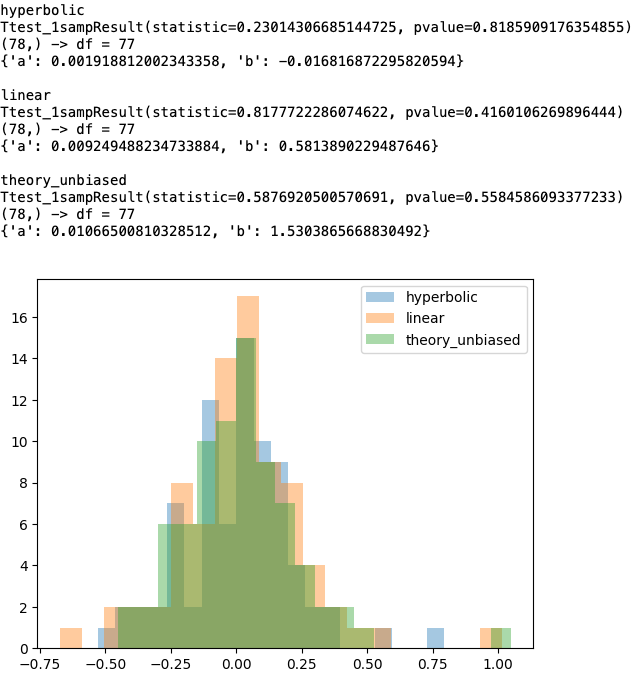

{'name': 'Arial'}
Distance from true value for different fits and distributions,
removed small sigma distributions and not showing outliers,
 mean for N=100 and 4.0<C<41.0
Cs in dataset from 2.000449467036685 - 79.9633071758464
Absolute percent error in estimating C
Tasks with reliability > 0.8


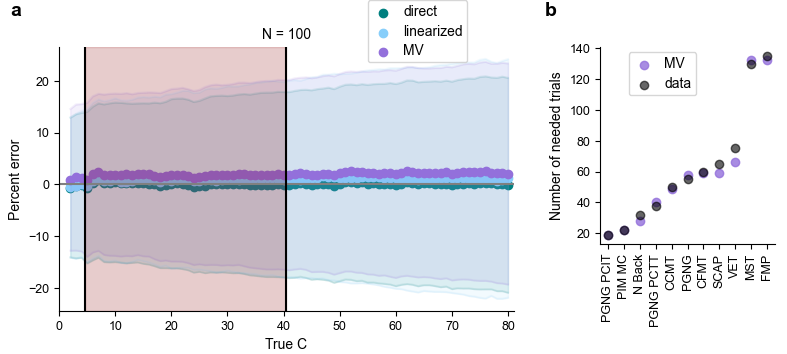

In [22]:
# define the min and max Csed on real-world data
my_C_max = np.ceil(Cs_data.max())
my_C_min = np.floor(Cs_data.min())
my_N=100

#######################
# define canvas

from cand import Canvas, Vector, Point

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10

cmap_fits = ['teal', 'lightskyblue', "mediumpurple"]#'darkorange']


# CanD
a = 20
b = 9
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=10, ticksize=9)

# letters
c.add_text("a", Point(.02, 0.97), weight="bold", size=font_size)
c.add_text("b", Point(.7, 0.97), weight="bold", size=font_size)
           
# titles
titles = [f'Distance from true value for different fits and distributions,\nremoved small sigma distributions and not showing outliers,\n mean for N={my_N} and {my_C_min}<C<{my_C_max}\nCs in dataset from {df_perc_median_noexplosions["true_C"].min()} - {df_perc_median_noexplosions["true_C"].max()}', 
          'Absolute percent error in estimating C', f'Tasks with reliability > {rel_thr}']
# c.add_text(titles[0], Point(.27, 0.947), size=font_size)
for title in titles:
    print(title)

# ### GRID
offset_l = 1.5 #from left
offset_top = 1.2 #top row from top
offset_m_top = 0.2 # middle row top
offset_bottom = 2.8
end_panel = 16#1.7

# offset = 1.5
panel_width = (a//2-offset_l+end_panel)/2+0.4
hsb = 1.1 #half_space_between
# hsb2=1.

## left panel A
c.add_grid(["method_comparison"], 1, Point(offset_l+panel_width+hsb, offset_bottom, "cm"), Point(a-0.32, b-offset_top, "cm"), spacing=Vector(.5, 2.5, "cm"))

## top row, panel B
c.add_grid(["error_shaded"], 1, Point(offset_l, offset_bottom-1.7, "cm"), Point(offset_l+panel_width-hsb, b-offset_top, "cm"), spacing=Vector(.5, 2.5, "cm"))


######### panel A, replace "theory" with "analytical" to be consistent with the paper
plot_perc_median_error_shaded(
    df_perc_median_noexplosions.replace("linear", "linearized").replace("theory_unbiased", "MV").replace("hyperbolic","direct"),
    Cs_data, c.ax('error_shaded'), fits_list=["direct", "linearized", "MV"], cmap_fits=cmap_fits,
    shaded_area_alpha=0.2, shaded_area_colour='darkred',
    min_C_thr=0, max_C_thr=np.ceil(df_perc_median_noexplosions["true_C"].max())+1, my_N=my_N)

# fix the legend position
c.ax('error_shaded').legend(title='', bbox_to_anchor=(0.91,.92), fontsize=8)

c.ax("error_shaded").set_ylabel('Percent error')

######### panel B
plot_app_vs_data_predictions(df_estimate_n_needed, c.ax('method_comparison'), ha='center', rot=90, app_colour=cmap_fits[-1])
# fix the legend position
c.ax('method_comparison').legend(bbox_to_anchor=(0.58,1.), fontsize=8) # with MV
c.ax('method_comparison').set_xlabel('',fontsize=2)

## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#

c.save(os.path.join(path_figures, "Fig4", 'Figure_4.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig4", 'Figure_4.pdf'), dpi=300)#, bbox_inches="tight")

---

## Figure 5

[top](#top)

##### Load data

In [23]:
# load the data from corrected simulations
df_median_noexplosions = pd.read_csv(os.path.join(path_simulation_general, "simulate_unbiasedC_error", "multi", f"df_perc_median_noexplosions.csv"))


{'name': 'Arial'}
Median percent error
Standard deviation of percent error
number of simulations: 1000
median range from -69.35012638994696 - 25.96910945296981 with thr -25
 -  4: median range from -0.395583398545801 - 21.75899176953284
The max error is for L=20 and N=10
The min error is for L=70 and N=200


/Users/jan/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jan/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


 -  16: median range from -38.20154959044984 - 22.813701088983976
The max error is for L=50 and N=10
The min error is for L=10 and N=10
 -  30: median range from -69.35012638994696 - 25.96910945296981
The max error is for L=120 and N=10
The min error is for L=10 and N=10
std range from 9.859234764734602 - 504.34294215832085 with thr 100
 -  4: std range from 9.859234764734602 - 504.34294215832085
The max error is for L=10 and N=10
The min error is for L=150 and N=190
 -  16: std range from 10.276120428388085 - 317.58036195509595
The max error is for L=20 and N=10
The min error is for L=230 and N=200
 -  30: std range from 10.980647329053076 - 240.95083318453413
The max error is for L=20 and N=10
The min error is for L=240 and N=200


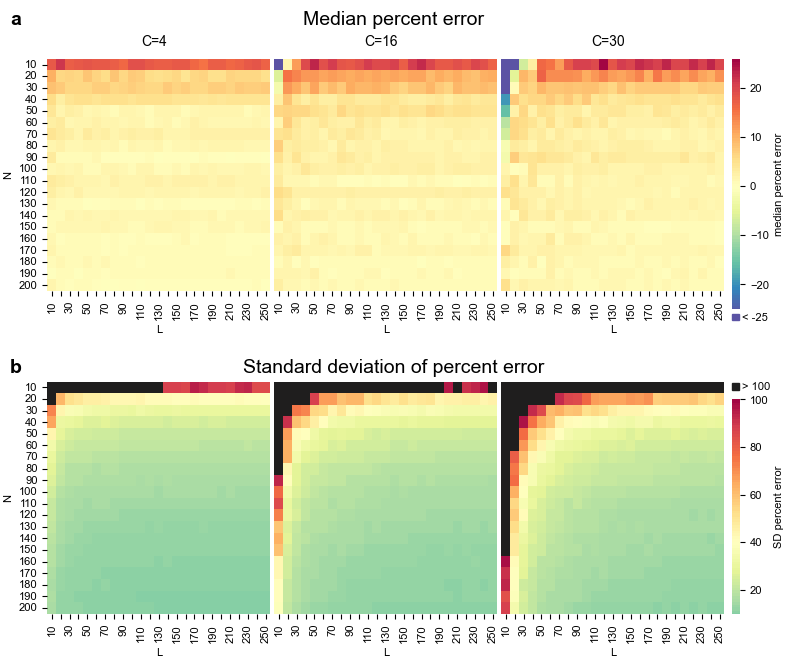

In [24]:
#######################
# define canvas

from cand import Canvas, Vector, Point
# for legend
import matplotlib.patches as mpatches

# reset params just in case
plt.rcdefaults()

font_size=14
legend_size=10
matrix_fontsize=5

# define selection
C_selection = [4, 16, 30]

# create matrices
arr_median = np.zeros((len(C_selection), df_median_noexplosions["N"].unique().size, df_median_noexplosions["total_n_trials"].unique().size))
arr_std = np.zeros((len(C_selection), df_median_noexplosions["N"].unique().size, df_median_noexplosions["total_n_trials"].unique().size))
for j, special_C in enumerate(C_selection):
    # recreate the error matrix
    for i, N in enumerate(df_median_noexplosions["N"].unique()):    
        arr_median[j,i] = df_median_noexplosions.loc[(df_median_noexplosions["N"]==N)&(df_median_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error.values
        arr_std[j,i] = df_median_noexplosions.loc[(df_median_noexplosions["N"]==N)&(df_median_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error_std.values



# define what errors to show in black
error_std_thr = 100
cmap_error = sns.color_palette("icefire", n_colors=1, desat=1)
error_median_thr = -25
cmap_median_error = sns.color_palette("Spectral_r", n_colors=100)[:1]

# define xtick and yticks labels
L_range = df_median_noexplosions["total_n_trials"].unique()
N_range = df_median_noexplosions["N"].unique()

# CanD
a = 20
b = 17
# rot = 15
c = Canvas(a, b, "cm")

# set font
c.set_font("Arial", size=8)

# letters
c.add_text("a", Point(.02, 0.97), weight="bold", size=font_size)
c.add_text("b", Point(.02, 0.45), weight="bold", size=font_size)

           
# titles
titles = ['Median percent error', 'Standard deviation of percent error']
c.add_text(titles[0], Point(.5, 0.97), size=font_size)
c.add_text(titles[1], Point(.5, 0.45), size=font_size)
# c.add_text(titles[2], Point(.47, 0.5), size=font_size)
for title in titles:
    print(title)
print(f'number of simulations: {df_median_noexplosions["n_sim"].unique()[0]}')

# ### GRID
# # top row, panel A

right_offset = 1.2
left_offset = 1.2
bottom_offset = 1.4
top_offset = 1+0.5
hsb = 1.8+0.5
vsb = 0.1
colourbar_offset = 0.2
colourbar_width = .4
c.add_grid([f"medianC{i}" for i in range(3)]+[f"stdC{i}" for i in range(3)], 2, Point(left_offset, bottom_offset, "cm"), Point(a-right_offset-colourbar_width, b-top_offset, "cm"), spacing=Vector(vsb, hsb, "cm"))
c.add_grid(["mean_colourbar"], 1, Point(a-right_offset+colourbar_offset-colourbar_width, b//2+hsb/2, "cm"), Point(a-right_offset, b-top_offset, "cm"), spacing=Vector(.5, 2.5, "cm"))
c.add_grid(["std_colourbar"], 1, Point(a-right_offset+colourbar_offset-colourbar_width, bottom_offset, "cm"), Point(a-right_offset, b//2-hsb/2, "cm"), spacing=Vector(.5, 2.5, "cm"))
    

######### panel A
print(f'median range from {arr_median.min()} - {arr_median.max()} with thr {error_median_thr}')
for j, special_C in enumerate(C_selection):
    print(f' -  {special_C}: median range from {arr_median[j].min()} - {arr_median[j].max()}')
    # get indiced of the largest and smallest error
    ind_max_N, ind_max_L = np.unravel_index(np.argmax(arr_median[j], axis=None), arr_median[j].shape)
    ind_min_N, ind_min_L = np.unravel_index(np.argmin(arr_median[j], axis=None), arr_median[j].shape)
    # print
    print(f'The max error is for L={L_range[ind_max_L]} and N={N_range[ind_max_N]}')
    print(f'The min error is for L={L_range[ind_min_L]} and N={N_range[ind_min_N]}')
    
    # plot the low error
    sns.heatmap(np.where(arr_median[j]<error_median_thr, arr_median[j], np.nan), 
                cbar=False, 
                ax=c.ax(f"medianC{j}"),
                cmap=cmap_median_error,
               )
    
    sns.heatmap(np.where(arr_median[j]>=error_median_thr, arr_median[j], np.nan),
                xticklabels=df_median_noexplosions["total_n_trials"].unique(), yticklabels=df_median_noexplosions["N"].unique(),
                cbar_kws={"label":"median percent error"},
                cbar=j//2,
                cmap=sns.color_palette("Spectral_r", n_colors=100),#sns.color_palette("vlag", as_cmap=True),
                center=0, vmax=arr_median.max(), vmin=error_median_thr,
                annot_kws={"size": matrix_fontsize},
                ax=c.ax(f"medianC{j}"),
                cbar_ax=c.ax("mean_colourbar"),
               )
    
    c.add_text(f"C={special_C}", Point(12, -1.5, f"medianC{j}"), size=legend_size)
    if j>0:
        c.ax(f"medianC{j}").set_yticks([])
    
    # take only every second
    c.ax(f"medianC{j}").set_xticklabels(['' if i%2==1 else x for i,x in enumerate(c.ax(f"medianC{j}").get_xticklabels())])
    
    c.ax(f"medianC{j}").set_xlabel('L')
    
    
c.ax("medianC0").set_ylabel('N')

## --------------------------------------------------

#### plot B

print(f'std range from {arr_std.min()} - {arr_std.max()} with thr {error_std_thr}')
for j, special_C in enumerate(C_selection):
    print(f' -  {special_C}: std range from {arr_std[j].min()} - {arr_std[j].max()}')
    # get indiced of the largest and smallest error
    ind_max_N, ind_max_L = np.unravel_index(np.argmax(arr_std[j], axis=None), arr_std[j].shape)
    ind_min_N, ind_min_L = np.unravel_index(np.argmin(arr_std[j], axis=None), arr_std[j].shape)
    # print
    print(f'The max error is for L={L_range[ind_max_L]} and N={N_range[ind_max_N]}')
    print(f'The min error is for L={L_range[ind_min_L]} and N={N_range[ind_min_N]}')
    
    # plot the high error
    sns.heatmap(np.where(arr_std[j]>=error_std_thr, arr_std[j], np.nan), 
                cbar=False, 
                ax=c.ax(f"stdC{j}"),
                cmap=cmap_error,
               )
    
    
    g = sns.heatmap(np.where(arr_std[j]<error_std_thr, arr_std[j], np.nan),#arr_std[j], 
                xticklabels=df_median_noexplosions["total_n_trials"].unique(), yticklabels=df_median_noexplosions["N"].unique(),
                cbar_kws={"label":"SD percent error"},
                cbar=j//2,
                cmap=sns.color_palette("Spectral_r", n_colors=100),#sns.color_palette("vlag", as_cmap=True),
                center=40, vmin=arr_std.min(), vmax=error_std_thr,#arr_std.max(),
                annot_kws={"size": matrix_fontsize},
                ax=c.ax(f"stdC{j}"),
                cbar_ax=c.ax("std_colourbar"),
                
               )
    
    c.ax(f"stdC{j}").set_xlabel('L')
    if j>0:
        c.ax(f"stdC{j}").set_yticks([])
    
    # take only every second
    c.ax(f"stdC{j}").set_xticklabels(['' if i%2==1 else x for i,x in enumerate(c.ax(f"stdC{j}").get_xticklabels())])

c.ax("stdC0").set_ylabel('N')

# add a label for the colour
# https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
colors = [cmap_error[0]]
texts = [f"> {error_std_thr}"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
leg = c.ax("stdC2").legend(handles=patches, bbox_to_anchor=(1.055, .98), loc='center', frameon=False, )

# make the legend to be squares
for patch in leg.get_patches():
    patch.set_height(5)
    patch.set_width(5)
    patch.set_x(21)

    
# add a label for the colour
# https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
colors = [cmap_median_error[0]+(1,)]
texts = [f"< {error_median_thr}"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
leg = c.ax("medianC2").legend(handles=patches, bbox_to_anchor=(1.05, -.11), loc='center', frameon=False, )

# make the legend to be squares
for patch in leg.get_patches():
    patch.set_height(5)
    patch.set_width(5)
    patch.set_x(21)
## --------------------------------------------------    
    
# c.debug_grid(Vector(0.5,0.5,"cm"))
c.show()
#
c.save(os.path.join(path_figures, "Fig5", 'Figure_5.png'), dpi=300)#, bbox_inches="tight")
c.save(os.path.join(path_figures, "Fig5", 'Figure_5.pdf'), dpi=300)#, bbox_inches="tight")

----

In [25]:
# there is a bug in watermark which prevents it from seeing some "from ... import" imports, see 
# https://github.com/rasbt/watermark/issues/77, so I load it here separately
import lmfit

%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Wed Jun 05 2024

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

lmfit     : 1.0.3
seaborn   : 0.11.1
numpy     : 1.19.1
matplotlib: 3.6.2
pandas    : 1.2.4
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]



[top](#top)